# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay

import pandas as pd
import seaborn as sns

# project root (one level above 'notebooks/') to the path - go to the parent of 'src/'
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.optimizers.sa_nn import sa_nn
from src.optimizers.gd_nn import gd_nn
from src.problems.nn import init_weights, flatten_weights, unflatten_weights

In [137]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo 

In [ ]:
# random seed set
np.random.seed(0)

In [ ]:
wine_data = load_wine()
df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
df['target'] = wine_data.target
df = df[['target'] + [col for col in df.columns if col != 'target']]

In [171]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# extract features and target
X = wine_quality.data.features
y = wine_quality.data.targets

# concatenate target and features into one dataframe, with target as first column
df = pd.concat([y, X], axis=1)
df.columns = ['target'] + list(X.columns)

In [172]:
# group target into 3 classes: 0 (low), 1 (medium), 2 (high)
df["target_grouped"] = df["target"].map(lambda x: 0 if x <= 5 else 1)

# move target_grouped to first column
cols = ["target_grouped"] + [col for col in df.columns if col not in ["target_grouped", "target"]]
df = df[cols]

In [173]:
df.head()

,target_grouped,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


# Basic EDA

In [174]:
df.describe()

,target_grouped,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,0.633061,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,0.482007,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,0.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,1.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target_grouped        6497 non-null   int64  
 1   fixed_acidity         6497 non-null   float64
 2   volatile_acidity      6497 non-null   float64
 3   citric_acid           6497 non-null   float64
 4   residual_sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [176]:
df['target_grouped'].value_counts()


target_grouped
1    4113
0    2384
Name: count, dtype: int64

In [164]:
df.isnull().sum()

target_grouped          0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

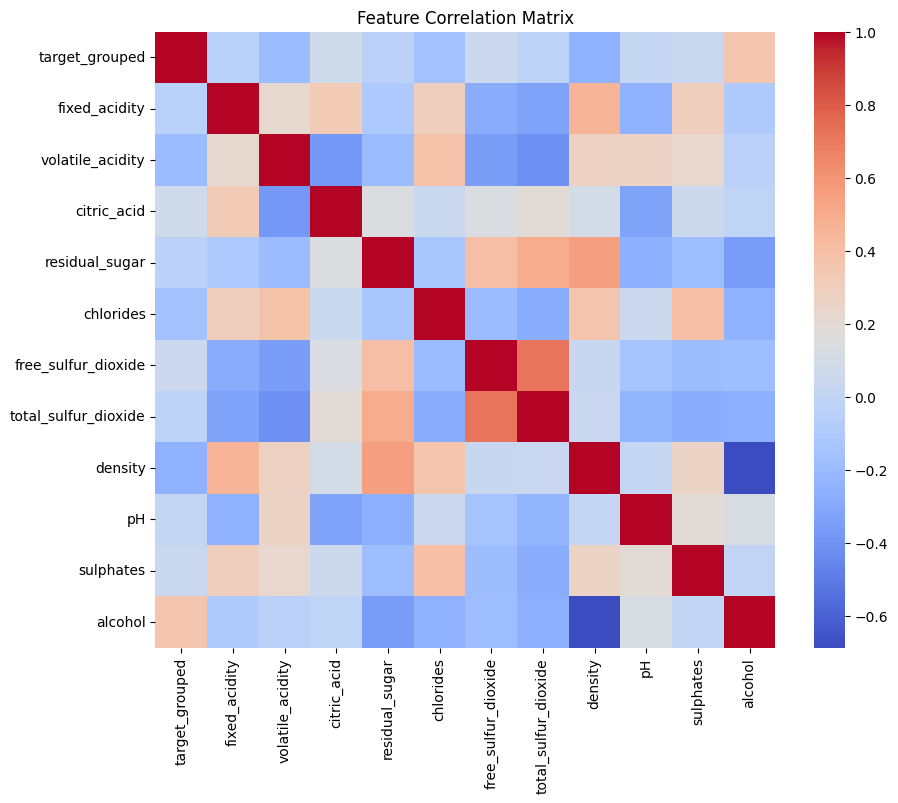

In [165]:
# feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

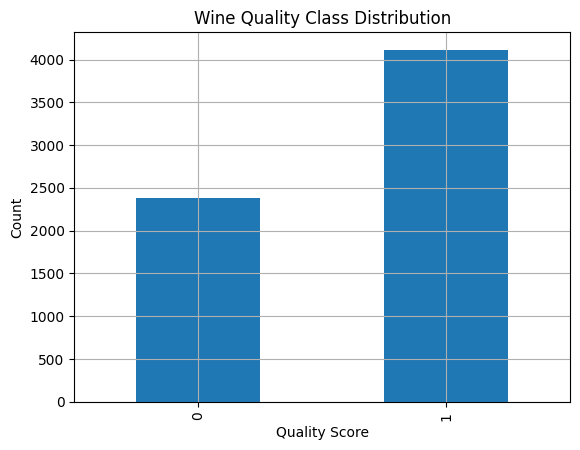

In [177]:
df['target_grouped'].value_counts().sort_index().plot(kind='bar')
plt.title("Wine Quality Class Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Preprocessing

In [178]:
X = df.drop(columns=["target_grouped"]).values
y = df["target_grouped"].values

# normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape:", X.shape)
print("Classes:", np.bincount(y))

Shape: (6497, 11)
Classes: [2384 4113]


In [179]:
# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# NN Architecture

In [180]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def flatten_model_weights(model):
    return torch.cat([p.view(-1) for p in model.parameters()]).detach().cpu().numpy()

def set_model_weights(model, flat_weights):
    with torch.no_grad():
        offset = 0
        for p in model.parameters():
            shape = p.shape
            size = p.numel()
            new_weights = flat_weights[offset:offset+size].reshape(shape)
            p.copy_(torch.tensor(new_weights, dtype=p.dtype))
            offset += size

In [181]:
# Define layer sizes
input_dim = X_temp.shape[1]
hidden_dim = 16
output_dim = len(np.unique(y_temp))
layer_sizes = [input_dim, hidden_dim, output_dim]

# Cross-validation setup
n_splits = 5
outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# GD

In [217]:
# GD
val_accuracies_gd = []
val_losses_gd = []
trained_models_gd = []

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_temp, y_temp)):
    print(f"[GD]    Fold {fold+1} training.")
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp[train_idx], y_temp[val_idx]

    model = SimpleNN(input_dim, hidden_dim, output_dim)
    result = gd_nn(model, X_train, y_train, X_val, y_val,
                   loss_type="cross_entropy", optimizer_type="sgd",
                   lr=0.01, batch_size=16, epochs=50,
                   track_val_loss=True, track_val_accuracy=True,
                   early_stopping=True, verbose=False)

    best_x, _, train_loss, val_loss, _, val_accs = result
    set_model_weights(model, best_x)

    val_accuracy = val_accs[-1] if val_accs else 0.0
    val_accuracies_gd.append(val_accuracy)
    val_losses_gd.append(val_loss[-1] if val_loss else 0.0)
    trained_models_gd.append(model)

    print(f"[Fold {fold+1}] Validation Accuracy = {val_accuracy:.4f}")

[GD]    Fold 1 training.
[Fold 1] Validation Accuracy = 0.7615
[GD]    Fold 2 training.
[Fold 2] Validation Accuracy = 0.7462
[GD]    Fold 3 training.
[Fold 3] Validation Accuracy = 0.7786
[GD]    Fold 4 training.
[Fold 4] Validation Accuracy = 0.7411
[GD]    Fold 5 training.
[Fold 5] Validation Accuracy = 0.7575



[GD] Best Fold: 3 | Test Accuracy = 0.7608

[GD] Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.6921    0.6268    0.6579       477
           1     0.7949    0.8384    0.8161       823

    accuracy                         0.7608      1300
   macro avg     0.7435    0.7326    0.7370      1300
weighted avg     0.7572    0.7608    0.7580      1300



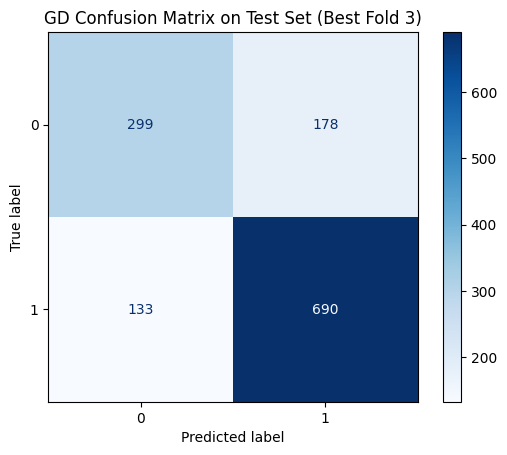

In [219]:
# pick best model (highest validation accuracy)
best_fold_gd = int(np.argmax(val_accuracies_gd))
best_model_gd = trained_models_gd[best_fold_gd]

# evaluate on held-out test set
best_model_gd.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    preds = best_model_gd(X_test_tensor).argmax(dim=1).numpy()

    acc = accuracy_score(y_test, preds)
    print(f"\n[GD] Best Fold: {best_fold_gd+1} | Test Accuracy = {acc:.4f}")

    # classification report
    print("\n[GD] Classification Report on Test Set:")
    print(classification_report(y_test, preds, digits=4))

    # confusion matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(f"GD Confusion Matrix on Test Set (Best Fold {best_fold_gd+1})")
    plt.grid(False)
    plt.show()

# SA

In [215]:
# SA
val_accuracies_sa = []
val_losses_sa = []
trained_models_sa = []

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_temp, y_temp)):
    print(f"[SA] Fold {fold+1} start")

    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp[train_idx], y_temp[val_idx]

    model = SimpleNN(input_dim, hidden_dim, output_dim)
    x_init = flatten_model_weights(model)
    layer_sizes = [input_dim, hidden_dim, output_dim]

    result = sa_nn(
        x_init=x_init,
        layer_sizes=layer_sizes,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        loss_type="cross_entropy",
        step_size=0.001,
        alpha = 0.999,
        max_iter=200000,
        track_val_loss=True,
        track_val_accuracy=True,
        early_stopping=True,
        verbose=False,
        patience = 10, 
        adaptive_step_size = False
    )

    best_x, _, train_loss, val_loss, _, val_accs = result
    set_model_weights(model, best_x)

    val_accuracy = val_accs[-1] if val_accs else 0.0
    val_accuracies_sa.append(val_accuracy)
    val_losses_sa.append(val_loss[-1] if val_loss else 0.0)
    trained_models_sa.append(model)

    print(f"[SA] Fold {fold+1} Validation Accuracy = {val_accuracy:.4f}")

[SA] Fold 1 start
[SA] Fold 1 Validation Accuracy = 0.3548
[SA] Fold 2 start
[SA] Fold 2 Validation Accuracy = 0.4048
[SA] Fold 3 start
[SA] Fold 3 Validation Accuracy = 0.3927
[SA] Fold 4 start


[SA] Fold 4 Validation Accuracy = 0.6169
[SA] Fold 5 start
[SA] Fold 5 Validation Accuracy = 0.4601



[SA] Best Fold: 4 | Test Accuracy = 0.6085

[SA] Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.2500    0.0335    0.0591       477
           1     0.6270    0.9417    0.7528       823

    accuracy                         0.6085      1300
   macro avg     0.4385    0.4876    0.4060      1300
weighted avg     0.4887    0.6085    0.4983      1300



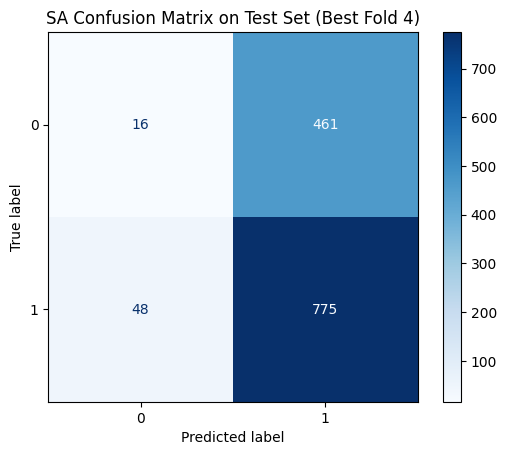

In [220]:
# pick best model (highest validation accuracy)
best_fold_sa = int(np.argmax(val_accuracies_sa))
best_model_sa = trained_models_sa[best_fold_sa]

# evaluate on held-out test set
best_model_sa.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    preds = best_model_sa(X_test_tensor).argmax(dim=1).numpy()

    acc = accuracy_score(y_test, preds)
    print(f"\n[SA] Best Fold: {best_fold_sa+1} | Test Accuracy = {acc:.4f}")

    # classification report
    print("\n[SA] Classification Report on Test Set:")
    print(classification_report(y_test, preds, digits=4))

    # confusion matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(f"SA Confusion Matrix on Test Set (Best Fold {best_fold_sa+1})")
    plt.grid(False)
    plt.show()